### Waiting periods for Studentenwerk München dorms after 2016
The versions of the "Wartezeiten, Mietpreise des Studentenwerks München" document were gathered through the Wayback Machine.

In [119]:
import pandas as pd
import tabula
import re
import numpy as np
import os
import plotly.graph_objects as go
import datetime

In [120]:
dirname = "./wartezeiten_mietpreisliste"

In [121]:
pdfs = [f for f in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, f)) and str(f).endswith("pdf")]

In [149]:
raw_files = []
for pdf in pdfs:
    df = tabula.read_pdf(dirname + "/" + pdf, pages="all", multiple_tables=True)
    raw_files.append(df)

In [150]:
aggregated = []
for df in raw_files:
    df_agg = pd.DataFrame()
    for i in range(len(df)):
        table = df[i]
        # https://stackoverflow.com/questions/33098383/merge-multiple-column-values-into-one-column-in-python-pandas
        table["cols"] = table[table.columns[:]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
        table = table[["cols"]]
        df[i] = pd.DataFrame(table[table["cols"].str.contains("Semester|Auf Anfrage")]["cols"])
        df_agg = df_agg.append(df[i], ignore_index=True)
    aggregated.append(df_agg)

In [152]:
all_dorms = ["Agnes-/ Adelheidstraße", "Biedersteiner Straße", "Chiemgaustraße", "Dachauer Straße",
            "Kaulbachstraße", "Kreittmayerstraße", "Lothstraße", "Notburgastraße", "Schwere-Reiter-Straße",
            "Türkenstraße", "Heiglhofstr.", "Sauerbruchstraße", "Stiftsbogen", "Westendstraße",
            "Studentenstadt", "Garching I ", "Garching II ", "Josef-Wirth-Weg", "Max-Bill-Straße",
            "Olympisches Dorf", "Felsennelkenanger", "Heidemannstraße", "Moosacher Straße", "Oberschleißheim",
            "Weihenstephan I ", "Weihenstephan II ", "Weihenstephan III ", "Weihenstephan IV ",
            "Rosenheim I ", "Rosenheim II "]

In [153]:
current_dorm = ""
wait_dict = {}
for j, df in enumerate(aggregated):
    waiting_times = {}
    #for i in range(len(df)):
    for index, row in df.iterrows():
        row = row[0]
        # allow differentiating between numerals like I and II
        row = row.replace("\r", " ")
        row = row.replace(",", " ")
        # exclude special apartment types
        if "behindertengerecht" not in row and "Alleinerziehend" not in row:
            mentioned_dorms = list(filter(lambda x: re.search(x, row) is not None, all_dorms))
            if len(mentioned_dorms) != 0:
                current_dorm = mentioned_dorms[0]
            # semester range giben
            match_multiple_semester = re.search(r"(\d)-(\d) Semester", row)
            times = 0
            if match_multiple_semester is not None:
                times = (int(match_multiple_semester.group(1)) + int(match_multiple_semester.group(2)))/2
            else:
                # exact semester given
                match_one_semester = re.search(r"(\d) Semester", row)
                if match_one_semester is not None:
                    times = int(match_one_semester.group(1))
            if times != 0:
                if current_dorm in waiting_times:
                    waiting_times[current_dorm] += [times]
                else:
                    waiting_times[current_dorm] = [times]
    for key in waiting_times:
        waiting_times[key] = np.mean(waiting_times[key])
    date = pdfs[j].split(".")[0]
    wait_dict[date] = waiting_times

In [154]:
dorm_dict = {}
for key in wait_dict.keys():
    dorms = wait_dict[key]
    for dorm in dorms:
        times = round(wait_dict[key][dorm], 2)
        if dorm not in dorm_dict:
            dorm_dict[dorm] = [times]
        else:
            dorm_dict[dorm] += [times]

In [167]:
dorm_dict = {}
for key in wait_dict.keys():
    for dorm in all_dorms:
        if dorm in wait_dict[key].keys():
            times = round(wait_dict[key][dorm], 2)
        else:
            times = np.nan
        if dorm not in dorm_dict:
            dorm_dict[dorm] = [times]
        else:
            dorm_dict[dorm] += [times]

In [171]:
dict((k, len([value for value in v if not np.isnan(value)])) for k,v in dorm_dict.items())

{'Agnes-/ Adelheidstraße': 11,
 'Biedersteiner Straße': 11,
 'Chiemgaustraße': 11,
 'Dachauer Straße': 10,
 'Kaulbachstraße': 3,
 'Kreittmayerstraße': 11,
 'Lothstraße': 11,
 'Notburgastraße': 11,
 'Schwere-Reiter-Straße': 11,
 'Türkenstraße': 11,
 'Heiglhofstr.': 11,
 'Sauerbruchstraße': 11,
 'Stiftsbogen': 11,
 'Westendstraße': 9,
 'Studentenstadt': 11,
 'Garching I ': 11,
 'Garching II ': 11,
 'Josef-Wirth-Weg': 11,
 'Max-Bill-Straße': 9,
 'Olympisches Dorf': 11,
 'Felsennelkenanger': 11,
 'Heidemannstraße': 11,
 'Moosacher Straße': 1,
 'Oberschleißheim': 11,
 'Weihenstephan I ': 11,
 'Weihenstephan II ': 10,
 'Weihenstephan III ': 11,
 'Weihenstephan IV ': 11,
 'Rosenheim I ': 11,
 'Rosenheim II ': 11}

Besides Kaulbachstraße and Moosacher Straße, which disappear from the PDFs around 2017, the list is generally complete.

In [172]:
x = [datetime.datetime.strptime(k, "%Y-%m-%d").date() for k in wait_dict.keys()]

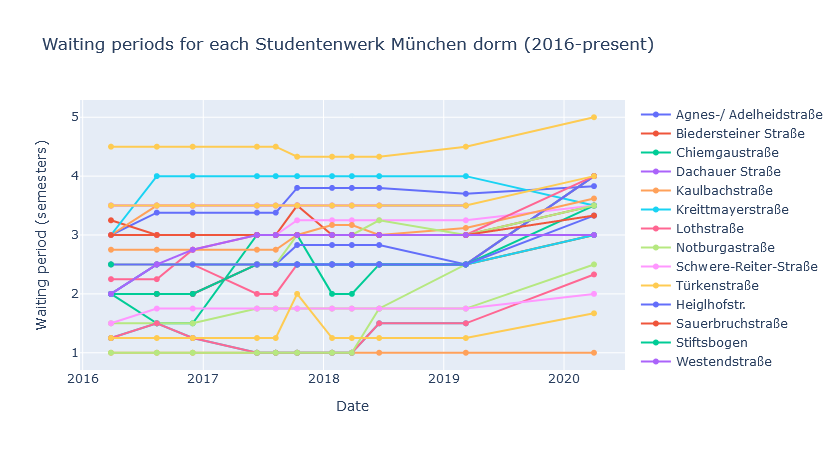

In [176]:
fig = go.Figure()

for dorm in dorm_dict:
    fig.add_trace(go.Scatter(x=x, y=dorm_dict[dorm], name=dorm.strip()))
    
fig.update_layout(title="Waiting periods for each Studentenwerk München dorm (2016-present)",
                 xaxis_title="Date",
                 yaxis_title="Waiting period (semesters)")

fig.show()
fig.write_html("index.html")

WS17/18 had a particularly large influx of students, leading to higher waiting times.